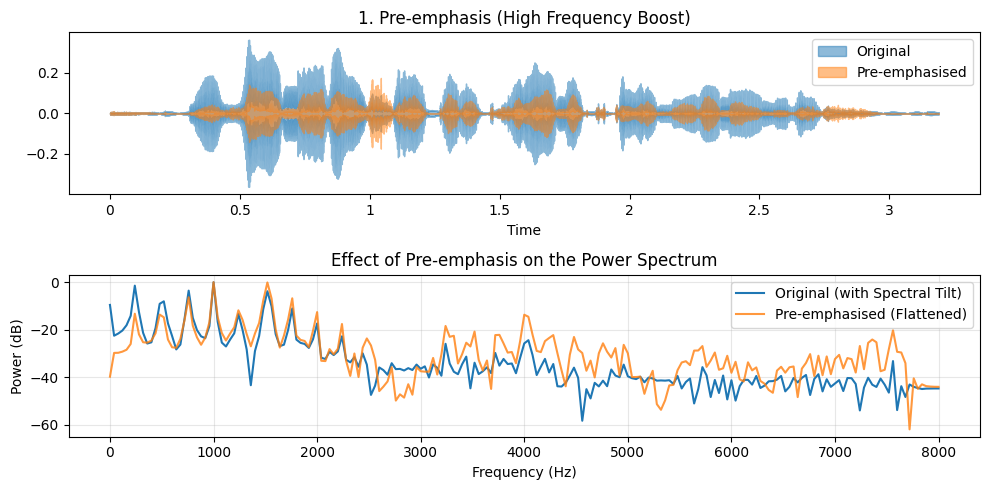

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

from IPython import display

# Load signal
y, sr = librosa.load("./data/BASIC5000_0001.wav", sr=16000)

alpha = 0.97
y_pre_np = np.append(y[0], y[1:] - alpha * y[:-1])
# Apply pre-emphasis (librosa has a function but we implement it manually here)
#y_pre = librosa.effects.preemphasis(y, coef=0.97)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5, label='Original')
librosa.display.waveshow(y_pre_np, sr=sr, alpha=0.5, label='Pre-emphasised')
plt.title('1. Pre-emphasis (High Frequency Boost)')
plt.legend()

# 400 samples = 25 ms at 16 kHz
# Calculate Power Spectrum (Magnitude of FFT)
# We use a single window for clarity
fft_orig = np.abs(np.fft.rfft(y[12100:12500]))**2
fft_pre = np.abs(np.fft.rfft(y_pre_np[12100:12500]))**2
freqs = np.fft.rfftfreq(400, 1/sr)

plt.subplot(2, 1, 2)
plt.plot(freqs, librosa.power_to_db(fft_orig, ref=np.max), label='Original (with Spectral Tilt)')
plt.plot(freqs, librosa.power_to_db(fft_pre, ref=np.max), label='Pre-emphasised (Flattened)', alpha=0.8)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Effect of Pre-emphasis on the Power Spectrum')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

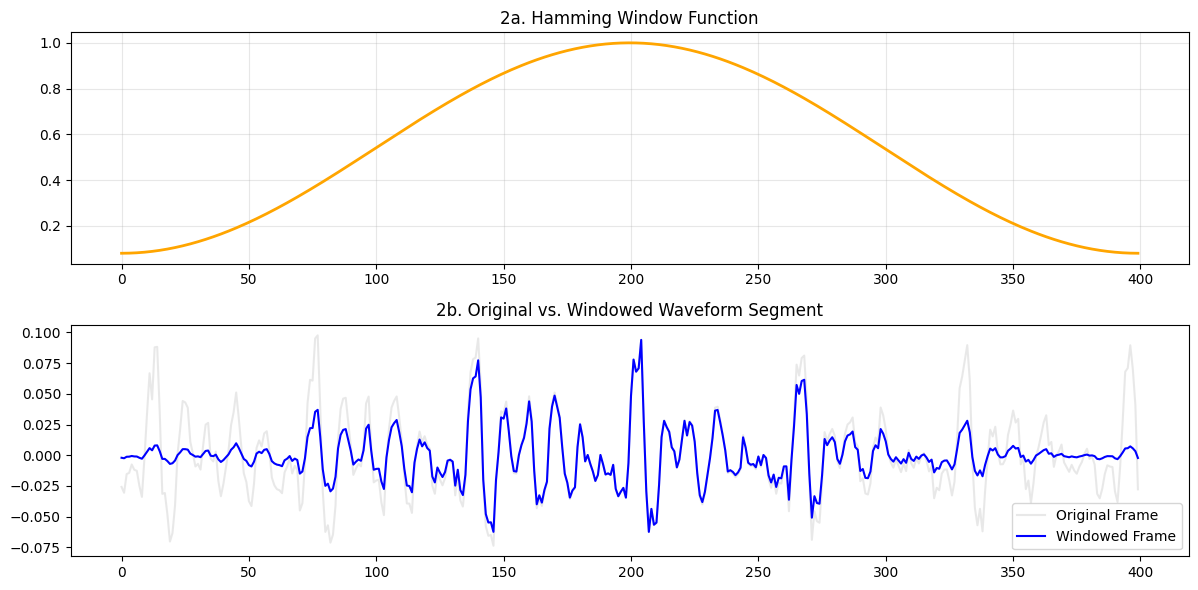

In [74]:
# --- STEP 2: Windowing (Hamming Window Shape & Effect) ---
win_length = 400 # 25ms at 16kHz
window = np.hamming(win_length)

# Let's grab a single frame of speech (e.g., in the middle of the signal)
start_sample = 12100 
audio_frame = y_pre_np[start_sample : start_sample + win_length]
windowed_frame = audio_frame * window

plt.figure(figsize=(12, 6))

# Plot the Window Shape
plt.subplot(2, 1, 1)
plt.plot(window, color='orange', lw=2)
plt.title('2a. Hamming Window Function')
plt.grid(True, alpha=0.3)

# Plot the Resulting Windowed Waveform
plt.subplot(2, 1, 2)
plt.plot(audio_frame, color='lightgray', label='Original Frame', alpha=0.5)
plt.plot(windowed_frame, color='blue', label='Windowed Frame', lw=1.5)
plt.title('2b. Original vs. Windowed Waveform Segment')
plt.legend()
plt.tight_layout()
plt.show()

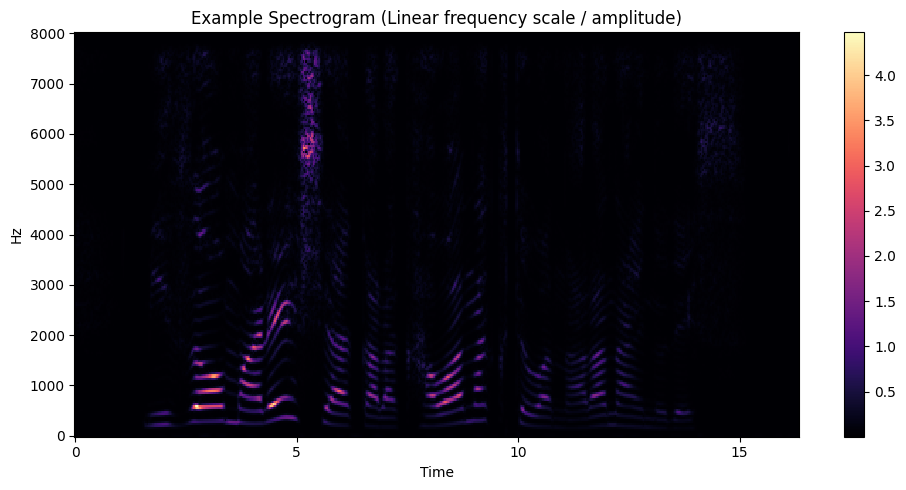

In [83]:
D = librosa.stft(y_pre_np, n_fft=win_length)  # STFT of y
S = np.abs(D)

plt.figure(figsize=(10, 5))
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='linear')

plt.colorbar()
plt.title('Example Spectrogram (Linear frequency scale / amplitude)')
plt.tight_layout()
plt.show()

In [61]:
# This shows a huge gap in representing intensity of frequency components by amplitude
print(np.max(S))
print(np.min(S))
print(np.mean(S))

15.377925
1.3012417e-09
0.18670794


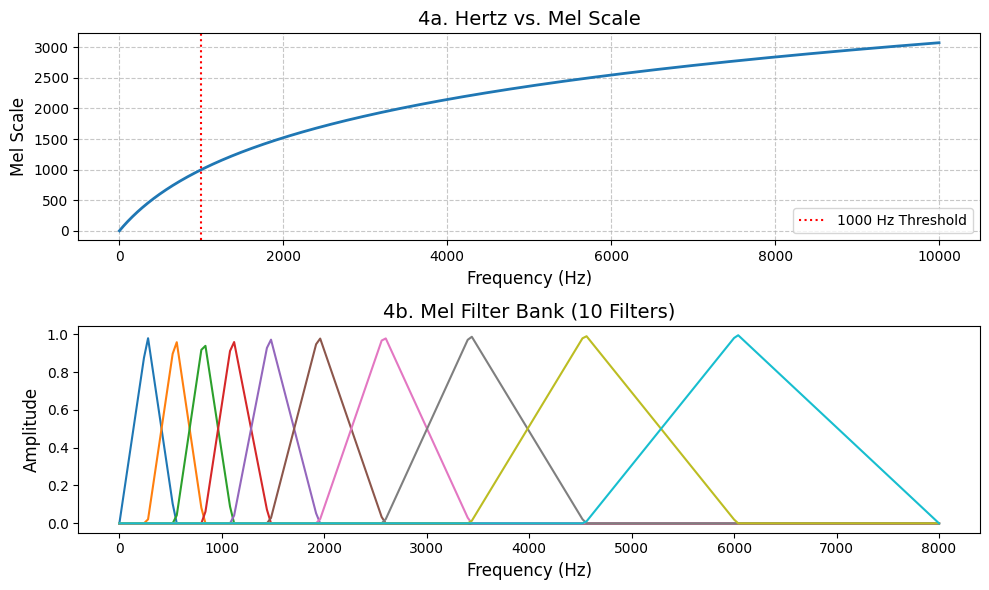

In [90]:
### Mel Scale Visualization ###
# Define the frequency range (0 to 10,000 Hz)
hz = np.linspace(0, 10000, 1000)

# Calculate Mel values using the standard formula
mel = 2595 * np.log10(1 + hz / 700)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(hz, mel, linewidth=2)

# Highlight the non-linear nature
plt.title('4a. Hertz vs. Mel Scale', fontsize=14)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Mel Scale', fontsize=12)

# Adding gridlines to show the curve clearly
plt.grid(True, linestyle='--', alpha=0.7)

# Mark the point where the scale starts becoming significantly non-linear
plt.axvline(x=1000, color='r', linestyle=':', label='1000 Hz Threshold')
plt.legend()


### Mel Filter Bank Visualization ###
mel_fb = librosa.filters.mel(
    sr=sr,
    n_fft=400,
    n_mels=10,
    fmin=0,
    fmax=8000,
    norm=None # norm="slaney" makes the amplitudes of later filters smaller
)
fft_freqs = librosa.fft_frequencies(sr=sr, n_fft=400)
plt.subplot(2, 1, 2)
for i in range(mel_fb.shape[0]):
    plt.plot(fft_freqs, mel_fb[i])
plt.title('4b. Mel Filter Bank (10 Filters)', fontsize=14)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Mel-filter banks are 10 filters and 201 frequency bins
print(mel_fb.shape)
# The number of frequency bins by FFT are also 201.
print(len(fft_freqs))
# 10 rows (filters) x 201 columns (frequency bins)
print(mel_fb)
# Weight of the first mel filter
print(mel_fb[0])
# Max weight of the first mel filter
print(max(mel_fb[0]))

(10, 201)
201
[[0.         0.1458704  0.2917408  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.04059695 0.02029848 0.        ]]
[0.         0.1458704  0.2917408  0.43761122 0.5834816  0.72935206
 0.87522244 0.97890717 0.8330367  0.68716633 0.54129595 0.39542553
 0.24955511 0.10368471 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.       

In [ ]:
def gen_audio(frequency, duration, sample_rate):
    t = np.linspace(0, duration, duration * sample_rate)
    return t, np.sin(2 * np.pi * frequency * t)

_, hz_2000 = gen_audio(2000, 3, 44100)
display.Audio(hz_2000, rate=44100)

In [103]:
_, hz_2005 = gen_audio(2005, 3, 44100)
display.Audio(hz_2005, rate=44100)

In [104]:
_, hz_100 = gen_audio(100, 3, 44100)
display.Audio(hz_100, rate=44100)

In [105]:
_, hz_105 = gen_audio(105, 3, 44100)
display.Audio(hz_105, rate=44100)

In [ ]:
import soundfile as sf
# save audio for demo
for freq in [2000, 2005, 100, 105]:
    _, audio = gen_audio(freq, 3, 44100)
    sf.write(f'./audio/sine_{freq}Hz.wav', audio, 44100)

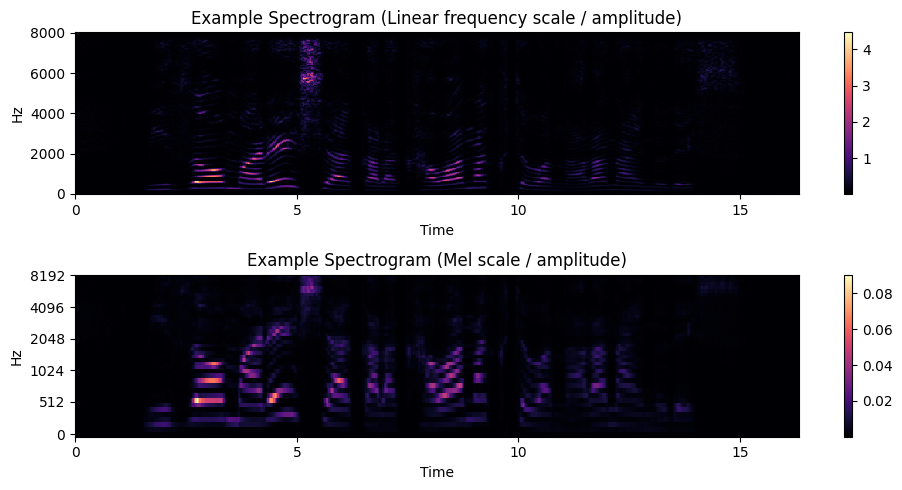

In [108]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)

D = librosa.stft(y_pre_np, n_fft=win_length)  # STFT of y
S = np.abs(D)

librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.title('Example Spectrogram (Linear frequency scale / amplitude)')
plt.tight_layout()


plt.subplot(2, 1, 2)
D = librosa.stft(y_pre_np, n_fft=win_length)  # STFT of y
S = np.abs(D)

# filter banks are often 40 mel bands
mel_fb = librosa.filters.mel(sr=sr, n_fft=win_length, n_mels=40, fmin=0, fmax=8000)
S_mel = np.dot(mel_fb, S)
librosa.display.specshow(S_mel, sr=sr, x_axis='time', y_axis='mel')

plt.colorbar()
plt.title('Example Spectrogram (Mel scale / amplitude)')
plt.tight_layout()
plt.show()

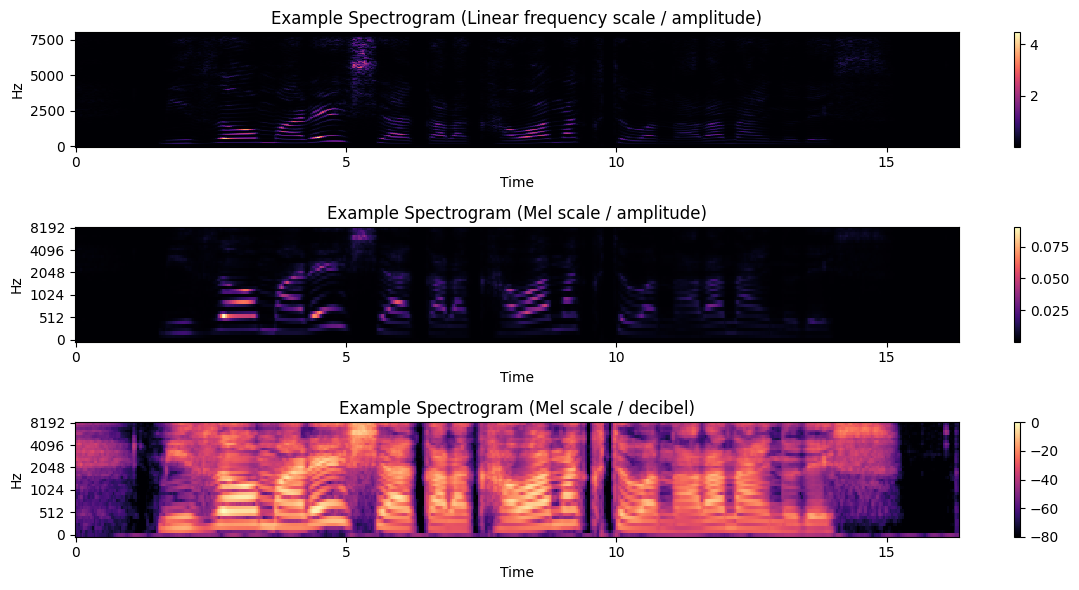

In [110]:
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)

D = librosa.stft(y_pre_np, n_fft=win_length)  # STFT of y
S = np.abs(D)

librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.title('Example Spectrogram (Linear frequency scale / amplitude)')


plt.subplot(3, 1, 2)
D = librosa.stft(y_pre_np, n_fft=win_length)  # STFT of y
S = np.abs(D)

# filter banks are often 40 mel bands
mel_fb = librosa.filters.mel(sr=sr, n_fft=win_length, n_mels=40, fmin=0, fmax=8000)
S_mel = np.dot(mel_fb, S)
librosa.display.specshow(S_mel, sr=sr, x_axis='time', y_axis='mel')

plt.colorbar()
plt.title('Example Spectrogram (Mel scale / amplitude)')


plt.subplot(3, 1, 3)
D = librosa.stft(y_pre_np, n_fft=win_length)  # STFT of y
S = np.abs(D) ** 2  # Power Spectrum

# filter banks are often 40 mel bands
mel_fb = librosa.filters.mel(sr=sr, n_fft=win_length, n_mels=40, fmin=0, fmax=8000)
S_mel = np.dot(mel_fb, S)
librosa.display.specshow(librosa.power_to_db(S_mel, ref=np.max), sr=sr, x_axis='time', y_axis='mel')

plt.colorbar()
plt.title('Example Spectrogram (Mel scale / decibel)')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'MFCC (13 coefficients)')

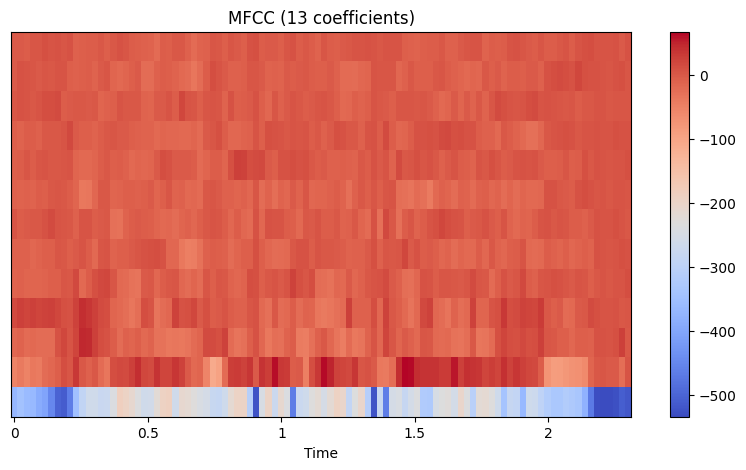

In [112]:
mfccs = librosa.feature.mfcc(y=y_pre_np, sr=sr, n_mfcc=13, n_fft=win_length, n_mels=40)
plt.figure(figsize=(10, 5))
img = librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar(img)
plt.title('MFCC (13 coefficients)')